In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [2]:
data_folder_left = "data_road/training/image_2/"
data_folder_right = "data_road/training_right/image_3/"
data_folder_calib = "data_road/training/calib/"
cat = ['uu', 'uum', 'um']
IDX_LEN = 6

In [3]:
idx_num = 1
cat_idx = 2
fname = cat[cat_idx]+'_'+str(idx_num).zfill(IDX_LEN)
img_fname = fname + '.png'
calib_fname = fname + '.txt'

In [4]:
img_left_color = cv2.imread(data_folder_left + img_fname)
img_right_color = cv2.imread(data_folder_right + img_fname)

In [5]:
img_left_bw = cv2.blur(cv2.cvtColor(img_left_color, cv2.COLOR_RGB2GRAY),(5,5))
img_right_bw = cv2.blur(cv2.cvtColor(img_right_color, cv2.COLOR_RGB2GRAY),(5,5))

In [127]:
def showImg(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    
def write_ply(fn, verts, colors):
    ply_header = '''ply
    format ascii 1.0
    element vertex %(vert_num)d
    property float x
    property float y
    property float z
    property uchar red
    property uchar green
    property uchar blue
    end_header
    '''
    out_colors = colors.copy()
    verts = verts.reshape(-1, 3)
    verts = np.hstack([verts, out_colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')

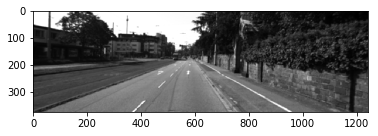

In [9]:
plt.imshow(img_right_bw, cmap='gray')

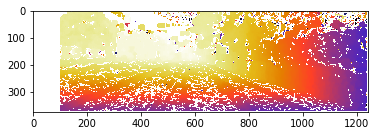

In [10]:
stereo = cv2.StereoBM_create(numDisparities=96, blockSize=11)
disparity = stereo.compute(img_left_bw,img_right_bw)

img = disparity.copy()
plt.imshow(img, 'CMRmap_r')

In [118]:
# Reading calibration
matrix_type_1 = 'P2'
matrix_type_2 = 'P3'

calib_file = data_folder_calib + calib_fname
with open(calib_file, 'r') as f:
    fin = f.readlines()
    for line in fin:
        if line[:2] == matrix_type_1:
            calib_matrix_1 = np.array(line[4:].strip().split(" ")).astype('float32').reshape(3,-1)
        elif line[:2] == matrix_type_2:
            calib_matrix_2 = np.array(line[4:].strip().split(" ")).astype('float32').reshape(3,-1)


Reading calibration...


In [120]:
# Calculate depth-to-disparity
cam1 = calib_matrix_1[:,:3] # left image - P2
cam2 = calib_matrix_2[:,:3] # right image - P3

Tmat = np.array([0.54, 0., 0.])

rev_proj_matrix = np.zeros((4,4))

cv2.stereoRectify(cameraMatrix1 = cam1,cameraMatrix2 = cam2, \
                  distCoeffs1 = 0, distCoeffs2 = 0, \
                  imageSize = img_left_color.shape[:2], \
                  R = np.identity(3), T = Tmat, \
                  R1 = None, R2 = None, \
                  P1 =  None, P2 =  None, Q = rev_proj_matrix);


Calculate depth-to-disparity


In [130]:
points = cv2.reprojectImageTo3D(img, rev_proj_matrix)

#reflect on x axis
reflect_matrix = np.identity(3)
reflect_matrix[0] *= -1
points = np.matmul(points,reflect_matrix)

#extract colors from image
colors = cv2.cvtColor(img_left_color, cv2.COLOR_BGR2RGB)

#filter by min disparity
mask = img > img.min()
out_points = points[mask]
out_colors = colors[mask]

#filter by dimension
idx = np.fabs(out_points[:,0]) < 4.5
out_points = out_points[idx]
out_colors = out_colors.reshape(-1, 3)
out_colors = out_colors[idx]

write_ply('out.ply', out_points, out_colors)
print('%s saved' % 'out.ply')

/Users/uks/.virtualenvs/vision_space_py3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less


out.ply saved


In [123]:
reflected_pts = np.matmul(out_points, reflect_matrix)
projected_img,_ = cv2.projectPoints(reflected_pts, np.identity(3), np.array([0., 0., 0.]), \
                          cam2[:3,:3], np.array([0., 0., 0., 0.]))
projected_img = projected_img.reshape(-1, 2)

In [128]:
blank_img = np.zeros(img_left_color.shape, 'uint8')
img_colors = img_right_color[mask][idx].reshape(-1,3)

for i, pt in enumerate(projected_img):
    pt_x = int(pt[0])
    pt_y = int(pt[1])
    if pt_x > 0 and pt_y > 0:
        # use the BGR format to match the original image type
        col = (int(img_colors[i, 2]), int(img_colors[i, 1]), int(img_colors[i, 0]))
        cv2.circle(blank_img, (pt_x, pt_y), 1, col)

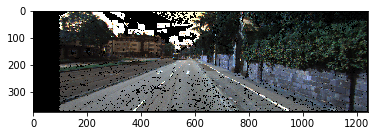

In [125]:
showImg(blank_img)